In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the dataset

path_to_dataset = 'FinalData.csv'
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    #CHANGE THIS
    colab_path = "/content/drive/MyDrive/Colab Notebooks/NTU_DA/"
    path_to_dataset = colab_path + path_to_dataset

    IN_COLAB = True
except:
    IN_COLAB = False

df = pd.read_csv(path_to_dataset, parse_dates=True)
df["day_in_a_week"] = pd.to_datetime(df["datetime"]).dt.dayofweek #Get the day in a week
df["month"] = pd.to_datetime(df["datetime"]).dt.month #Get month
df = df.drop('datetime', axis=1) #We remove the date

In [2]:
#Dataset information
categorical_variables = ["mrt_station", "hour", "day", "status", "day_in_a_week", "month"]

y_ind = df.columns.get_loc("mrt_flow")
cat_indices = [df.columns.get_loc(categorical_variables[i]) for i in range(len(categorical_variables))]
real_indices = [i for i in list(range(0, len(df.columns))) if (i not in cat_indices and i != y_ind)]
print("metro_flow index: ", y_ind, "\ncategorical indices: ", cat_indices, "\nnumerical indices: ", real_indices)

unique_station_names = list(dict.fromkeys([df["mrt_station"][i] for i in range(len(df))]))
print("\nunique_station_names:", unique_station_names)

unique_status = list(dict.fromkeys([df["status"][i] for i in range(len(df))]))
print("unique_status:", unique_status)

metro_flow index:  1 
categorical indices:  [0, 2, 3, 15, 31, 32] 
numerical indices:  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

unique_station_names: ['中山', '北投', '北門', '古亭', '士林', '大橋頭', '松山']
unique_status: ['良好', '普通', '對敏感族群不健康', nan, '對所有族群不健康']


In [3]:
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.compose
import sklearn.linear_model

data = df.to_numpy()


#Convert station names to ints
print("Processing station names")
for i in range(len(unique_station_names)):
    print("\tFirst occurance of " + unique_station_names[i] + ":", np.nonzero(data == unique_station_names[i])[0][0])
    data[data == unique_station_names[i]] = i

print("\nProcessing station status")
#Convert status names to ints
for i in range(len(unique_status)):
    occurances = np.nonzero(data == unique_status[i])[0]
    if len(occurances) > 0:
        print("\tFirst occurance of " + str(unique_status[i]) + ":", occurances[0])
    data[data == unique_status[i]] = i

#Replace missing values with NaNs
data[data == "-"] = np.nan

##Train test split
train_split_ratio = 0.7
val_split_ratio = 0.1
test_split_ratio = 0.2

sample_cnt = data.shape[0]
train_sz = int(train_split_ratio * sample_cnt)
val_sz = int(val_split_ratio * sample_cnt)
test_sz = int(test_split_ratio * sample_cnt)

val_ind = train_sz + val_sz
test_ind = val_ind + test_sz

print("\nTrain-val-test split")
print("\tTrain start index:", 0)
print("\tVal start index:", train_sz)
print("\tTest start index:", val_ind)

Y_train_raw = data[:train_sz, y_ind][:, None]
X_train_raw = data[:train_sz, cat_indices + real_indices]

Y_val_raw = data[train_sz:val_ind, y_ind][:, None]
X_val_raw = data[train_sz:val_ind, cat_indices + real_indices]

Y_test_raw = data[val_ind:test_ind, y_ind][:, None]
X_test_raw = data[val_ind:test_ind, cat_indices + real_indices]

##Preprocessing
new_cat_indices = list(range(len(cat_indices)))
new_real_indices = list(range(len(cat_indices), len(cat_indices) + len(real_indices)))

#One hot encoding for categories, Robust scaling for numerical values
X_preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ("cat", sklearn.preprocessing.OneHotEncoder(categories='auto', handle_unknown="ignore"), new_cat_indices),
        ("num", sklearn.preprocessing.RobustScaler(), new_real_indices)
    ]
)
X_preprocessor.fit(X_train_raw)
X_train = X_preprocessor.transform(X_train_raw)
X_val   = X_preprocessor.transform(X_val_raw)
X_test  = X_preprocessor.transform(X_test_raw)

Processing station names
	First occurance of 中山: 0
	First occurance of 北投: 1
	First occurance of 北門: 2
	First occurance of 古亭: 3
	First occurance of 士林: 4
	First occurance of 大橋頭: 5
	First occurance of 松山: 6

Processing station status
	First occurance of 良好: 0
	First occurance of 普通: 54
	First occurance of 對敏感族群不健康: 7556
	First occurance of 對所有族群不健康: 15096

Train-val-test split
	Train start index: 0
	Val start index: 52361
	Test start index: 59841


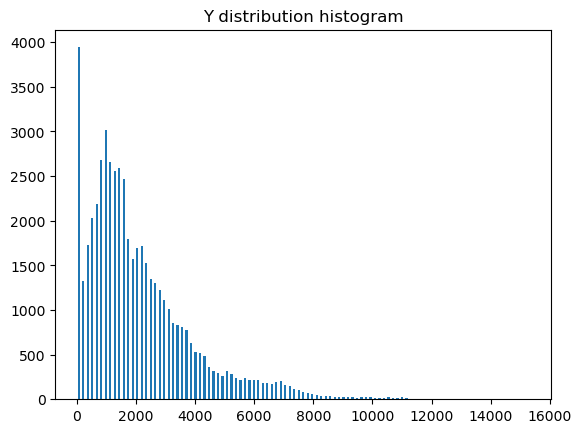

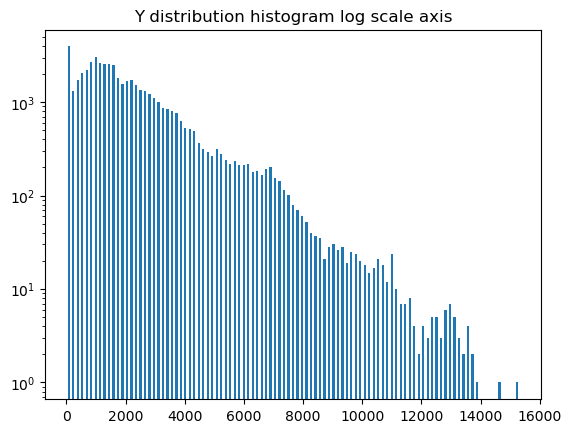

0 2111.500009549092 15170
Very low threshold: 486
Low threshold: 965
Low medium threshold: 1385
Medium threshold: 1912
High medium threshold: 2645
High threshold: 3817
Max value:  15170
[0, 486, 965, 1385, 1912, 2645, 3817]


In [30]:
step = Y_train_raw.max() / 100
e = 0.00001
bins = np.arange(Y_train_raw.min() - e, Y_train_raw.max() + step, step)

plt.hist(Y_train_raw, bins=bins, rwidth = 0.5)
plt.title("Y distribution histogram")
plt.show()

plt.hist(Y_train_raw, bins=bins, rwidth = 0.5)
plt.gca().set_yscale('log')
plt.title("Y distribution histogram log scale axis")
plt.show()

print(Y_train_raw.min(), Y_train_raw.mean(), Y_train_raw.max())

sorted_array = np.sort(Y_train_raw, axis = 0)[:, 0]

ratio = 7
class_freq = sorted_array.shape[0] // ratio
class_names = ["Very low", "Low", "Low medium", "Medium", "High medium", "High", "Very high"]
thresholds = []
thresholds.append(0)

for i in range(1, ratio):
    threshold = sorted_array[i * class_freq]
    print(class_names[i-1] + " threshold:", threshold)
    thresholds.append(threshold)
print("Max value: ", Y_train_raw.max())
print(thresholds)

#Get classes
def values_to_classes(Y_raw):
    Y = np.zeros_like(Y_raw)
    for i in range(1, ratio):
        Y[np.logical_and(Y_raw >= thresholds[i - 1], Y_raw < thresholds[i])] = i - 1
    Y[Y_raw >= thresholds[ratio - 1]] = ratio - 1
    return Y.astype(int)

Y_train_classes = values_to_classes(Y_train_raw)
Y_val_classes   = values_to_classes(Y_val_raw)
Y_test_classes  = values_to_classes(Y_test_raw)

Y_OneHot = sklearn.preprocessing.OneHotEncoder(categories='auto', handle_unknown="ignore").fit(Y_train_classes)
Y_train = Y_OneHot.transform(Y_train_classes)
Y_val   = Y_OneHot.transform(Y_val_classes)
Y_test  = Y_OneHot.transform(Y_test_classes)


# print(Y_train_raw)
# print(Y_train)
# print(Y_train.min(), Y_train.max())


#Replace NaNs with zeros
X_train[np.isnan(X_train)] = 0
X_val[np.isnan(X_val)] = 0
X_test[np.isnan(X_test)] = 0


# Sklearn Logistic Regression

In [36]:
LR = sklearn.linear_model.LogisticRegression(n_jobs=-1).fit(X_train, np.ravel(Y_train_classes))

def print_metrics(X, Y):
    Y_hat_prob = LR.predict_proba(X)

    Y_hat     = np.ravel(np.argmax(Y_hat_prob, axis = 1))
    Y_classes = np.ravel(np.argmax(Y, axis = 1))
    # print("\tAccuracy:", LR.score(X, Y_classes))
    print("\tAccuracy:", np.mean(Y_hat == Y_classes))
    print("\tCE Loss:", sklearn.metrics.log_loss(Y, Y_hat_prob))
    print("\tCE Loss:", sklearn.metrics.log_loss(Y, Y_hat_prob))

print("Train metrics:")
print_metrics(X_train, Y_train)
print("\nValidation metrics:")
print_metrics(X_val, Y_val)
print("\nTest metrics:")
print_metrics(X_test, Y_test)

[0 0 0 ... 4 1 2] [0 0 0 ... 4 1 2]
Train metrics:
	Accuracy: 0.5558908347816123
	CE Loss: 1.172788181996634

Validation metrics:
	Accuracy: 0.532620320855615
	CE Loss: 1.173793778269849

Test metrics:
	Accuracy: 0.5219251336898396
	CE Loss: 1.2640378897557134


# Sklearn MLP

In [ ]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(max_iter=2000, hidden_layer_sizes = (10000)).fit(X_train, np.ravel(Y_train))

def print_metrics(X, Y):
    Y_hat = MLP.predict(X)[:, None]

    MSE = np.mean((Y_hat - Y) ** 2)
    orig_MSE = np.mean((Y_scaler.inverse_transform(Y_hat) - Y_scaler.inverse_transform(Y)) ** 2)
    print("\tMSE:", MSE)
    print("\tOriginal scale MSE:", orig_MSE)

    print("\n\tRMSE:", np.sqrt(MSE))
    print("\tOriginal scale RMSE:", np.sqrt(orig_MSE))

    print("\n\tMAE:", np.mean(np.abs(Y_hat - Y)))
    print("\tOriginal scale MAE:", np.mean(np.abs(Y_scaler.inverse_transform(Y_hat) - Y_scaler.inverse_transform(Y))))

print("Train metrics:")
print_metrics(X_train, Y_train)
print("\nValidation metrics:")
print_metrics(X_val, Y_val)
print("\nTest metrics:")
print_metrics(X_test, Y_test)

# PyTorch initialization

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import copy
import time

default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

#Initialize PyTorch
USE_CUDA = False

cuda_available = torch.cuda.is_available()
print("Cuda available: ", cuda_available)
print("Using Cuda: ", USE_CUDA)

if cuda_available:
  # print(torch.cuda.current_device())
  # print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
  cuda_device = torch.device("cuda:0")

#Move the dataset to GPU
input_size = X_train.shape[1]
X_train_t = torch.from_numpy(X_train).to(dtype = default_dtype)
X_val_t   = torch.from_numpy(X_val  ).to(dtype = default_dtype)
X_test_t  = torch.from_numpy(X_test ).to(dtype = default_dtype)
Y_train_t = torch.from_numpy(Y_train).to(dtype = default_dtype)
Y_val_t   = torch.from_numpy(Y_val  ).to(dtype = default_dtype)
Y_test_t  = torch.from_numpy(Y_test ).to(dtype = default_dtype)

if USE_CUDA and cuda_available:
    X_train_t = X_train_t.cuda()
    X_val_t   = X_val_t.cuda()
    X_test_t  = X_test_t.cuda()
    Y_train_t = Y_train_t.cuda()
    Y_val_t   = Y_val_t.cuda()
    Y_test_t  = Y_test_t.cuda()

loss_functions = {
    'SmoothL1': F.smooth_l1_loss,
    'L1': F.l1_loss,
    'MSE': F.mse_loss
}

Cuda available:  True
Using Cuda:  False
NVIDIA GeForce RTX 3060


# PyTorch training implementation

In [ ]:
##Initialize model weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    torch.nn.init.xavier_uniform_(layer_in.weight, gain=0.5)
    layer_in.bias.data.fill_(0.0)

## Turn data into sequences that can be used for training
def get_batch_sequences(batch_idx, batch_size, permutation, X, Y):
    sample_sz = X.shape[0]

    batch_start = batch_idx * batch_size
    batch_end   = min(sample_sz, (batch_idx + 1) * batch_size)
    actual_size = batch_end - batch_start

    batch_indeces = permutation[batch_start:batch_end]
    batch_target = Y[batch_indeces]
    batch_data = X[batch_indeces]

    return [batch_data, batch_target, actual_size]

## Training step
def train(epoch, model, optimizer, scheduler, X, Y, batch_size, loss_fnc, print_mode):
    model.train()

    sample_sz = X.shape[0]
    perm = np.random.permutation(sample_sz)

    total_loss = 0
    for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
        batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y)

        output = model(batch_data)
        loss = loss_fnc(output, batch_target, reduction="mean")
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        # print(optimizer.param_groups[0]['lr'])
        if print_mode:
            print('Epoch:{} \tTrain loss: {:.7f}'.format(epoch, total_loss / (batch_idx + 1)), end="\r")

    total_loss /= np.ceil(sample_sz / batch_size)
    if not print_mode:
        print('Epoch:{} \tTrain loss: {:.7f}'.format(epoch, total_loss), end="\r")

    return total_loss

## Testing
def test(model, X, Y, batch_size, loss_fnc):
    model.eval()
    test_loss = 0

    sample_sz = X.shape[0]
    with torch.no_grad():
        perm = np.random.permutation(sample_sz)

        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y)

            output = model(batch_data)
            test_loss += loss_fnc(output, batch_target, reduction="mean").item()

    test_loss /= np.ceil(sample_sz / batch_size)
    return test_loss

def predict(model, X, batch_size):
    model.eval()
    test_loss = 0

    sample_sz = X.shape[0]
    Y_dummy = np.zeros((sample_sz, 1))
    Y_hat = np.zeros((sample_sz, 1))

    with torch.no_grad():
        perm = np.arange(0, sample_sz)

        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y_dummy)

            output = model(batch_data)

            start_idx = batch_idx * batch_size
            end_idx = start_idx + actual_size

            Y_hat[start_idx:end_idx] = output[:].cpu()

    return Y_hat

# Training and Grid search procedures

In [ ]:
## The whole training
def train_model(model_class, params, print_mode):
    model = model_class(params)
    loss_fnc = loss_functions[params["loss"]]
    epochs = params["epochs"]
    lr = params["lr"]
    batch_size = params["batch_size"]
    weight_decay = params["weight_decay"]


    if USE_CUDA and cuda_available:
      model = model.cuda()
    model.apply(weights_init)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    start_time = time.time()

    # Get initial performance
    test_loss = test(model, X_val_t, Y_val_t, batch_size, loss_functions[params["loss"]])
    if print_mode:
        print('\nInitial: Test loss: {:.7f}\n'.format(test_loss))

    # Train
    train_loss = None
    train_losses = []
    val_losses = []

    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(epochs * np.ceil(X_train_t.shape[0] / batch_size)), eta_min=0) #Cosine decay
    for epoch in range(1, epochs + 1):
        train_loss = train(epoch, model, optimizer, scheduler, X_train_t, Y_train_t, batch_size, loss_fnc, print_mode)

        if print_mode:
            # train_loss = test(model, X_train_t, Y_train_t, batch_size, loss_fnc)
            val_loss   = test(model, X_val_t, Y_val_t, batch_size, loss_fnc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print('Epoch:' + str(epoch) + ' \tTrain loss: {:.7f} \tVal loss: {:.7f}'.format(train_loss, val_loss))

    final_val_loss = None
    if not print_mode:
        final_val_loss = test(model, X_val_t, Y_val_t, batch_size, loss_fnc)
    else:
        final_val_loss = val_losses[-1]
    print("\nTime to train: {:.3f}s\t final val loss:{:.7f}".format(time.time() - start_time, final_val_loss))

    if print_mode:
        return [model, train_losses, val_losses]
    else:
        return [model, train_loss, final_val_loss]

## Grid search
def grid_search(model_class, param_variations):
    best_val_loss = float("inf")
    best_params = None

    grid_val_losses = []
    grid_train_losses = []

    for i in range(len(param_variations)):
        params = param_variations[i]
        print("\nGrid search step {}/{}".format(i + 1, len(param_variations)), "\t| params:", params)

        model, train_loss, val_loss = train_model(model_class, params, print_mode=False)

        grid_val_losses.append(val_loss)
        grid_train_losses.append(train_loss)

        if best_val_loss > val_loss:
            print("New best!")
            best_val_loss = val_loss
            best_params = params

    print("\nBest validation loss: ", best_val_loss)
    print("Best params: ", best_params)
    model, train_losses, val_losses = train_model(model_class, best_params, print_mode=True)
    return [model, train_losses, val_losses, best_params, grid_val_losses, grid_train_losses]

## Create list of parameter dictionaries for grid search
def create_param_dict_from_lists(list_of_params, list_of_names):
    params = []

    feature_vals = list_of_params[0]
    feature_name = list_of_names[0]
    for feature_val in feature_vals:
        params_row = {}
        params_row[feature_name] = feature_val
        params.append(params_row)

    for i in range(1, len(list_of_params)):
        feature_vals = list_of_params[i]
        feature_name = list_of_names[i]

        old_params = params
        new_params = []
        for past_param in old_params:
            for feature_val in feature_vals:
                params_row = copy.copy(past_param)
                params_row[feature_name] = feature_val
                new_params.append(params_row)
        params = new_params

    return params

## Grid search plotting
def plot_grid(grid_values, title, x_label, y_label, x_values, y_values):
    plt.matshow(grid_values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.colorbar()
    plt.xticks(list(range(len(x_values))), x_values)
    plt.yticks(list(range(len(y_values))), y_values)

    for (i, j), z in np.ndenumerate(grid_values):
        plt.text(j, i, '{:0.5f}'.format(z), ha='center', va='center')

    plt.show()

## Plot training progress
def plot_losses(train_losses, val_losses, title):
    plt.title(title)
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel("epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

## Evaluation
def evaluate_model(model, batch_size):
    def print_metrics(model, X, Y, batch_size):
        Y_hat = predict(model, X, batch_size)

        MSE = np.mean((Y_hat - Y) ** 2)
        orig_MSE = np.mean((Y_scaler.inverse_transform(Y_hat) - Y_scaler.inverse_transform(Y)) ** 2)
        print("\tMSE:", MSE)
        print("\tOriginal scale MSE:", orig_MSE)

        print("\n\tRMSE:", np.sqrt(MSE))
        print("\tOriginal scale RMSE:", np.sqrt(orig_MSE))

        print("\n\tMAE:", np.mean(np.abs(Y_hat - Y)))
        print("\tOriginal scale MAE:", np.mean(np.abs(Y_scaler.inverse_transform(Y_hat) - Y_scaler.inverse_transform(Y))))

    print("Train metrics:")
    print_metrics(model, X_train_t, Y_train, batch_size)
    print("\nValidation metrics:")
    print_metrics(model, X_val_t, Y_val, batch_size)
    print("\nTest metrics:")
    print_metrics(model, X_test_t, Y_test, batch_size)

# PyTorch Linear Regression implementation

In [ ]:
class Linear_Regression(nn.Module):
    def __init__(self, params):
        super(Linear_Regression, self).__init__()
        self.fc = nn.Linear(input_size, 1)

        self.p = params["dropout_rate"]
        if self.p != None:
            self.dropout = nn.Dropout(self.p)

    def forward(self, x):
        if self.p != None:
            x = self.dropout(x)
        x = self.fc(x)
        return x

# PyTorch Linear Regression training using MSE Loss

In [ ]:
# Parameters for grid search
epochs = [50]
batch_size = [20, 50]
dropout_rate = [None]
lrs = [5e-4, 1e-4, 5e-5]
weight_decay = [0]

loss = ["MSE"]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, loss, weight_decay, dropout_rate]
feature_names = ["epochs", "batch_size", "lr", "loss", "weight_decay", "dropout_rate"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:")
for param in params:
    print("\t", param)

# Grid search
model_LR, train_losses_LR, val_losses_LR, best_params, grid_val_losses, grid_train_losses = grid_search(Linear_Regression, params)

All grid searched values:
	 {'epochs': 200, 'batch_size': 20, 'lr': 0.0005, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 20, 'lr': 0.0001, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 20, 'lr': 5e-05, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 50, 'lr': 0.0005, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 50, 'lr': 0.0001, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 50, 'lr': 5e-05, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}

Grid search step 1/6 	| params: {'epochs': 200, 'batch_size': 20, 'lr': 0.0005, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
Epoch:200 	Train loss: 0.1833504
Time to train: 65.290s	 final val loss:0.1986630
New best!

Grid search step 2/6 	| params: {'epochs': 200, 'batch_size': 20, 'lr': 0.0001, 'loss': 'MSE', 'weight_decay':

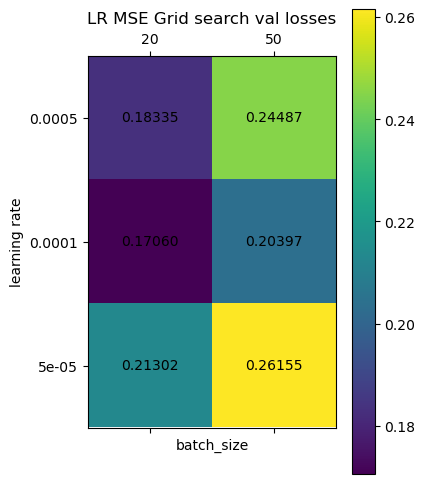

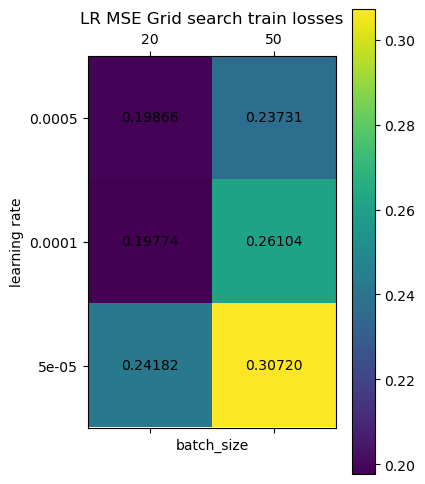

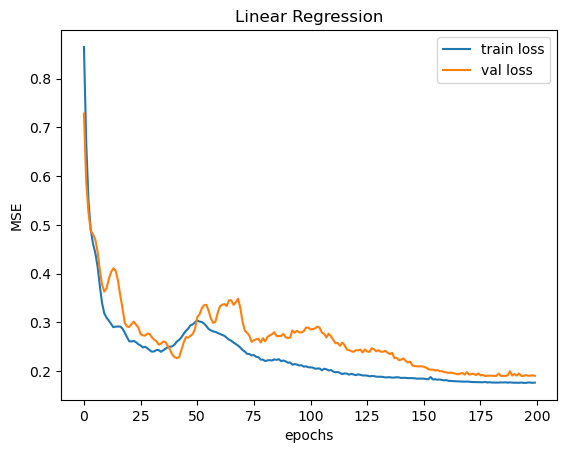

best_params:  {'epochs': 200, 'batch_size': 20, 'lr': 0.0001, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
Train metrics:
	MSE: 0.17583375661165918
	Original scale MSE: 1007744.7559079791

	RMSE: 0.4193253588940921
	Original scale RMSE: 1003.8649091924566

	MAE: 0.29081678634302544
	Original scale MAE: 696.215386505203

Validation metrics:
	MSE: 0.19108257427663242
	Original scale MSE: 1095139.3286669096

	RMSE: 0.43712992836985254
	Original scale RMSE: 1046.489048517427

	MAE: 0.3166006648793523
	Original scale MAE: 757.9419917211694

Test metrics:
	MSE: 0.18893367587933302
	Original scale MSE: 1082823.4848119651

	RMSE: 0.4346650157067314
	Original scale RMSE: 1040.588047601915

	MAE: 0.3102952817126575
	Original scale MAE: 742.8469044201022


In [ ]:
# Show grid search progress
train_grid = np.zeros((len(lrs), len(batch_size)))
val_grid = np.zeros((len(lrs), len(batch_size)))

for i in range(len(grid_val_losses)):
    train_grid[i % len(lrs), i // len(lrs)] = grid_train_losses[i]
    val_grid[i % len(lrs), i // len(lrs)] = grid_val_losses[i]

plot_grid(grid_values=train_grid, title="LR MSE Grid search val losses", x_label="batch_size", y_label="learning rate", x_values=batch_size, y_values=lrs)
plot_grid(grid_values=val_grid, title="LR MSE Grid search train losses", x_label="batch_size", y_label="learning rate", x_values=batch_size, y_values=lrs)

# Plot the training progress
plot_losses(train_losses_LR, val_losses_LR, "Linear Regression")

# Show final model evaluation
print("best_params: ", best_params)
evaluate_model(model_LR, batch_size=1000)

# PyTorch Linear Regression training using MAE Loss

In [ ]:
# Parameters for grid search
loss = ["L1"]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, loss, weight_decay, dropout_rate]
feature_names = ["epochs", "batch_size", "lr", "loss", "weight_decay", "dropout_rate"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:")
for param in params:
    print("\t", param)

# Grid search
model_LR, train_losses_LR, val_losses_LR, best_params, grid_val_losses, grid_train_losses = grid_search(Linear_Regression, params)

All grid searched values:
	 {'epochs': 200, 'batch_size': 20, 'lr': 0.0005, 'loss': 'L1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 20, 'lr': 0.0001, 'loss': 'L1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 20, 'lr': 5e-05, 'loss': 'L1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 50, 'lr': 0.0005, 'loss': 'L1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 50, 'lr': 0.0001, 'loss': 'L1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 50, 'lr': 5e-05, 'loss': 'L1', 'weight_decay': 0, 'dropout_rate': None}

Grid search step 1/6 	| params: {'epochs': 200, 'batch_size': 20, 'lr': 0.0005, 'loss': 'L1', 'weight_decay': 0, 'dropout_rate': None}
Epoch:200 	Train loss: 0.2750572
Time to train: 64.722s	 final val loss:0.3134672
New best!

Grid search step 2/6 	| params: {'epochs': 200, 'batch_size': 20, 'lr': 0.0001, 'loss': 'L1', 'weight_decay': 0, 'dro

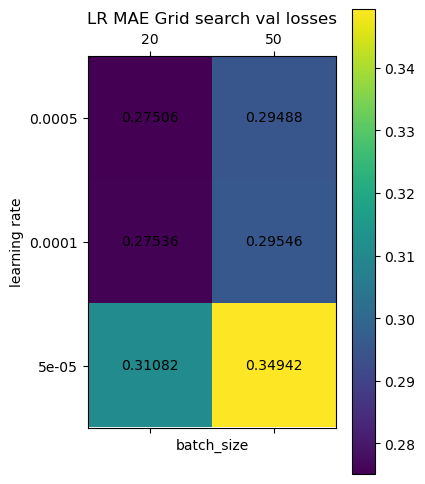

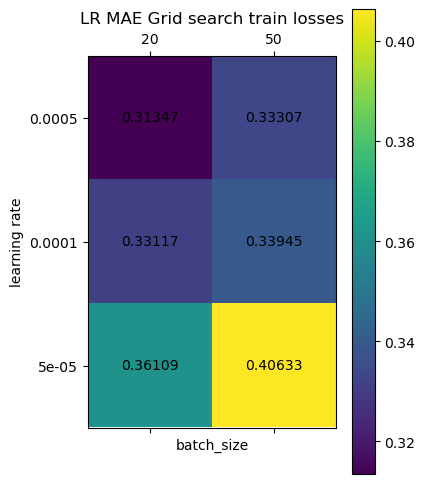

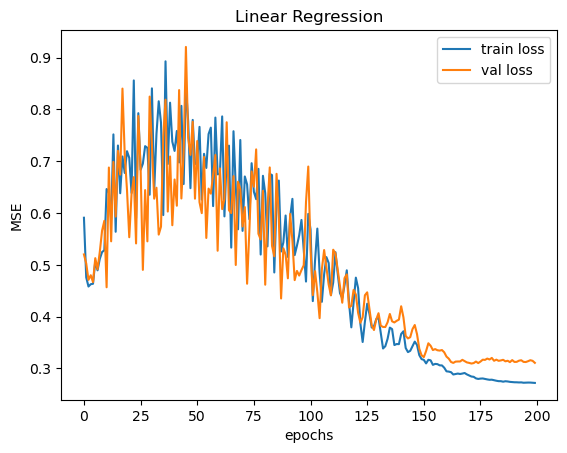

best_params:  {'epochs': 200, 'batch_size': 20, 'lr': 0.0005, 'loss': 'L1', 'weight_decay': 0, 'dropout_rate': None}
Train metrics:
	MSE: 0.17400257802370947
	Original scale MSE: 997249.8392622926

	RMSE: 0.41713616245023577
	Original scale RMSE: 998.6239729058644

	MAE: 0.2724131981413416
	Original scale MAE: 652.1571963503718

Validation metrics:
	MSE: 0.2039943191394528
	Original scale MSE: 1169139.585647521

	RMSE: 0.45165730276333715
	Original scale RMSE: 1081.2675828154293

	MAE: 0.3134351160869057
	Original scale MAE: 750.3636679120523

Test metrics:
	MSE: 0.17720802078143574
	Original scale MSE: 1015620.9881913128

	RMSE: 0.4209608304598371
	Original scale RMSE: 1007.7802281208501

	MAE: 0.2911129756522444
	Original scale MAE: 696.9244637114732


In [ ]:
# Show grid search progress
train_grid = np.zeros((len(lrs), len(batch_size)))
val_grid = np.zeros((len(lrs), len(batch_size)))

for i in range(len(grid_val_losses)):
    train_grid[i % len(lrs), i // len(lrs)] = grid_train_losses[i]
    val_grid[i % len(lrs), i // len(lrs)] = grid_val_losses[i]

plot_grid(grid_values=train_grid, title="LR MAE Grid search val losses", x_label="batch_size", y_label="learning rate", x_values=batch_size, y_values=lrs)
plot_grid(grid_values=val_grid, title="LR MAE Grid search train losses", x_label="batch_size", y_label="learning rate", x_values=batch_size, y_values=lrs)

# Plot the training progress
plot_losses(train_losses_LR, val_losses_LR, "Linear Regression")

# Show final model evaluation
print("best_params: ", best_params)
evaluate_model(model_LR, batch_size=1000)

# PyTorch Linear Regression training using Smooth MAE Loss

In [ ]:
# Parameters for grid search
loss = ["SmoothL1"]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, loss, weight_decay, dropout_rate]
feature_names = ["epochs", "batch_size", "lr", "loss", "weight_decay", "dropout_rate"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:")
for param in params:
    print("\t", param)

# Grid search
model_LR, train_losses_LR, val_losses_LR, best_params, grid_val_losses, grid_train_losses = grid_search(Linear_Regression, params)

All grid searched values:
	 {'epochs': 200, 'batch_size': 20, 'lr': 0.0005, 'loss': 'SmoothL1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 20, 'lr': 0.0001, 'loss': 'SmoothL1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 20, 'lr': 5e-05, 'loss': 'SmoothL1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 50, 'lr': 0.0005, 'loss': 'SmoothL1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 50, 'lr': 0.0001, 'loss': 'SmoothL1', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 200, 'batch_size': 50, 'lr': 5e-05, 'loss': 'SmoothL1', 'weight_decay': 0, 'dropout_rate': None}

Grid search step 1/6 	| params: {'epochs': 200, 'batch_size': 20, 'lr': 0.0005, 'loss': 'SmoothL1', 'weight_decay': 0, 'dropout_rate': None}
Epoch:200 	Train loss: 0.0817808
Time to train: 74.312s	 final val loss:0.1044930
New best!

Grid search step 2/6 	| params: {'epochs': 200, 'batch_size': 20, 'lr': 0.0

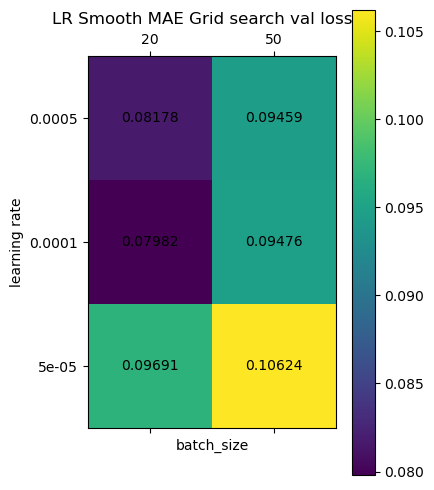

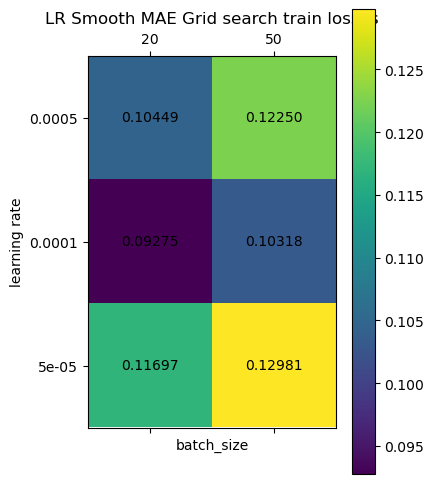

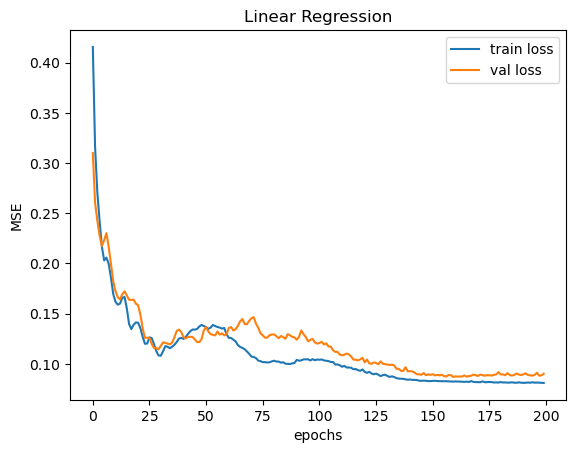

best_params:  {'epochs': 200, 'batch_size': 20, 'lr': 0.0001, 'loss': 'SmoothL1', 'weight_decay': 0, 'dropout_rate': None}
Train metrics:
	MSE: 0.1749842740412268
	Original scale MSE: 1002876.1708189445

	RMSE: 0.4183112167289168
	Original scale RMSE: 1001.4370528490268

	MAE: 0.28963662957174474
	Original scale MAE: 693.3900911947569

Validation metrics:
	MSE: 0.18408054372540636
	Original scale MSE: 1055009.039098623

	RMSE: 0.4290460857826422
	Original scale RMSE: 1027.1363293636455

	MAE: 0.31309607069545936
	Original scale MAE: 749.5519932449297

Test metrics:
	MSE: 0.19536933773162554
	Original scale MSE: 1119707.7817036507

	RMSE: 0.4420060381167044
	Original scale RMSE: 1058.1624552513904

	MAE: 0.3096530120791662
	Original scale MAE: 741.3093109175238


In [ ]:
# Show grid search progress
train_grid = np.zeros((len(lrs), len(batch_size)))
val_grid = np.zeros((len(lrs), len(batch_size)))

for i in range(len(grid_val_losses)):
    train_grid[i % len(lrs), i // len(lrs)] = grid_train_losses[i]
    val_grid[i % len(lrs), i // len(lrs)] = grid_val_losses[i]

plot_grid(grid_values=train_grid, title="LR Smooth MAE Grid search val losses", x_label="batch_size", y_label="learning rate", x_values=batch_size, y_values=lrs)
plot_grid(grid_values=val_grid, title="LR Smooth MAE Grid search train losses", x_label="batch_size", y_label="learning rate", x_values=batch_size, y_values=lrs)

# Plot the training progress
plot_losses(train_losses_LR, val_losses_LR, "Linear Regression")

# Show final model evaluation
print("best_params: ", best_params)
evaluate_model(model_LR, batch_size=1000)